# MODELING

Notebook for trying out various modeling algorithmns<br>
Read - model_data.csv<br>
Read - crystal_ball.csv - file containing data of companies from 2018 to be used in the api.<br> 
Write - a bunch of pickle files of some of the best models<br> 
Write - crystal_ball_web_ready.csv -- the final csv which we will use in our api to predict the future 

In [1]:
import os

# data frame basics
import pandas as pd
import numpy as np

# visualization basics
import matplotlib.pyplot as plt
import seaborn as sns

# math basics
from math import log
from scipy import stats, linalg

# Scikit learn Models and Selector Algos
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

# Scikit learn metrics and reporting
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc, recall_score

# stuff to change, process, oversample data
from sklearn import preprocessing 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pickle
# import warnings
# warnings.filterwarnings('ignore')

# old statsmodel stuf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.decomposition import PCA

# magics

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style("white")



In [2]:
# for random state parameters
RSEED = 0

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 1. LOAD DATA

In [4]:
model_data = pd.read_csv('../data/model_data_india.csv')
model_data = model_data.drop(columns = ['Unnamed: 0'])
model_data.head()

,sa_total_income,sa_sales,sa_total_assets,sa_pat,sa_total_liabilities,sa_gross_working_capital_cosm,sa_current_assets_incl_st_invest_loans,sa_current_liabilities,sa_cash_bal,sa_st_trade_bills_receivables,sa_debtors_more_6m,sa_st_trade_receivables,sa_nf_operating_expenses,sa_f_operating_expenses,sa_dep_owned_ast,sa_retained_profits,sa_pbit,sa_interest_inc,sa_interest_exp,sa_st_inventories,sa_pbdita_net_of_peoifi,sa_pbpt_net_of_peoi,sa_total_capital,sa_gross_fixed_assets,sa_pbdita,sa_cost_of_goods_sold,sa_cost_of_sales,sa_total_expense,sa_net_sales,sa_depreciation,sa_non_current_assets,sa_net_fixed_assets,sa_gross_fixed_assets.1,sa_non_fin_services_inc,sa_inc_fin_serv,sa_net_working_capital,sa_non_current_liabilities,sa_tot_inc_net_of_pe,sa_sales_n_chg_in_stk,sa_chg_in_assets_with_no_chg_in_efficiency,sa_chg_in_efficiency_with_no_chg_in_assets,sa_chg_in_efficiency_on_chg_in_assets,sa_reported_pat,sa_diff_in_pat,sa_pbpt,sa_pbt,sa_pbit_net_of_peoifi,sa_cash_profit,sa_equity_div_inc_dist_pc_pat,sa_sales_net_fixed_assets,sa_total_income_avg_tot_asset_net_miscexp_now_reval,sa_chg_in_efficiency_in_use_of_assets,sa_pc_chg_in_efficiency_with_no_chg_in_assets,sa_pc_chg_in_assets_with_no_chg_in_efficiency,sa_pc_chg_in_efficiency_on_chg_in_assets,sa_total_div_pc_pat,sa_total_interest_exp,sa_nf_oper_exp_pc_total_exp,sa_f_oper_exp_pc_total_exp,sa_fin_serv_exp_pc_total_exp,sa_pbpt_net_of_peoi_inc_fin_serv,sa_pat_cont_ops_pc_inc_cont_ops,sa_pat_discont_ops_pc_inc_discont_ops,sa_total_provisions_pc_pbdita,sa_write_offs_pc_pbdita,sa_depreciation_pc_pbdita,sa_amortisation_pc_pbdita,sa_fin_serv_exp_pc_pbdita,sa_prov_direct_tax_pc_pbdita,sa_pat_pc_pbdita,sa_pbdita_pc_total_inc,sa_pbt_pc_total_inc,sa_pat_pc_total_inc,sa_cash_profit_pc_total_inc,sa_pat_net_of_pe_pc_tot_inc_net_of_pe,sa_pat_net_of_pe_pc_avg_networth,sa_pat_pc_avg_networth,sa_cash_profit_pc_avg_networth,sa_pbpt_net_of_peoi_pc_avg_capital_employed,sa_pat_net_of_pe_pc_avg_capital_employed,sa_pat_pc_avg_capital_employed,sa_pat_net_of_pe_pc_avg_tot_asset_net_menow_reval,sa_pc_chg_in_profitability_with_no_chg_in_income,sa_st_trade_bills_receivables_pc_current_assets_incl_st_invest_loans,sa_quick_ratio,sa_current_ratio,sa_debt_equity,sa_cash_n_bank_no_fd_security_current_liab_n_prov,sa_cash_n_bank_no_fd_security_cost_of_sales_per_day,sa_rawmat_stores_spares_avg_stk_rawmat_stores,sa_cost_of_goods_sold_avg_stk_fg,sa_sales_avg_debtors,sa_creditors_turnover,sa_total_inc_net_of_pe_compensation_to_empl,sa_sales_avg_gfa_net_of_reval,sa_sales_net_repairs_avg_nfa_net_of_reval,equity_facevalue_on_stkdate,eps_on_stkdate,equity_bv_on_stkdate,high_price,stock_returns,market_cap,pe,pb,traded_qty,delisted
0,3741.8,3729.3,3661.4,131.6,3661.4,1606.7038,1557.9,1399.7,1.6,548.6,NaN,548.6,3177.5,3405.7,89.8,131.6,429.8,5.6,216.8,591.7,509.0,196.6,176.4,2384.5,519.6,2360.19,3319.6,3567.4,3569.9,89.8,2103.5,1560.3,2384.5,18.5,5.6,-40.0,901.1,3738.3,3686.5,198.5575,14.8090,0.8336,131.6,0.0,201.6,193.2,419.2,247.7,0.0000,239.0117,1.0683,1.1476,6.9136,92.6972,1.2432,0.0000,216.8,89.0705,95.4673,6.3968,35.1071,3.5170,0.0,1.5012,0.1155,17.2825,0.0,43.9184,11.8553,25.3272,13.8864,5.1633,3.5170,6.6198,3.4775,12.9039,13.0627,24.5868,7.8308,5.1780,5.2418,3.7114,75.0796,35.2141,0.5170,0.9745,1.2375,0.0499,10.7094,3.9417,12.2575,6.7237,4.0576,11.3042,1.6411,2.5176,5.0,4.4295,1250.3,63.95,1.1995,2214.2280,21.6022,1.7710,2699921.0,False
1,1330.2,1314.2,784.4,-164.6,784.4,427.8439,531.2,363.0,7.1,356.7,154.4,356.7,1316.5,1363.3,27.4,-164.6,-12.1,3.8,43.5,6.7,-0.7,-71.0,54.1,624.0,15.3,1204.75,1344.2,1496.4,1282.6,27.4,253.2,222.8,624.0,1194.9,3.9,85.3,143.5,1319.8,1315.8,-205.8565,151.4126,-22.1561,-165.2,0.6,-58.9,-177.5,-28.1,-32.1,NaN,589.8564,1.5181,0.5100,-197.6666,268.7421,42.7933,NaN,43.5,87.9778,91.1053,3.1275,-18.2051,-12.3741,0.0,0.0000,775.1634,179.0850,0.0,305.8824,-84.3137,-1075.8170,1.1502,-13.3439,-12.3741,-2.4132,-13.2596,-47.2781,-44.4685,-8.6722,-10.1371,-24.9857,-23.5009,-19.9715,103.4030,67.1498,1.1895,1.23

In [5]:
model_data.shape

(4770, 106)

In [6]:
model_data['delisted'].value_counts()

False    4295
True      475
Name: delisted, dtype: int64

In [7]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770 entries, 0 to 4769
Columns: 106 entries, sa_total_income to delisted
dtypes: bool(1), float64(105)
memory usage: 3.8 MB


We have just about 5000 data points 

### 2. LOAD CRYSTAL BALL
Load crystal_ball - aka data from 2018 that we are going to use to make predictions for 2019

In [8]:
crystal_ball=pd.read_csv('../data/crystal_ball.csv')
crystal_ball = crystal_ball.drop(columns ='Unnamed: 0')
crystal_ball.head()

,sa_finance1_cocode,sa_company_name,sa_finance1_year,sa_total_income,sa_sales,sa_total_assets,sa_pat,sa_total_liabilities,sa_gross_working_capital_cosm,sa_current_assets_incl_st_invest_loans,sa_current_liabilities,sa_cash_bal,sa_st_trade_bills_receivables,sa_debtors_more_6m,sa_st_trade_receivables,sa_nf_operating_expenses,sa_f_operating_expenses,sa_dep_owned_ast,sa_retained_profits,sa_pbit,sa_interest_inc,sa_interest_exp,sa_st_inventories,sa_pbdita_net_of_peoifi,sa_pbpt_net_of_peoi,sa_total_capital,sa_gross_fixed_assets,sa_pbdita,sa_cost_of_goods_sold,sa_cost_of_sales,sa_total_expense,sa_net_sales,sa_depreciation,sa_non_current_assets,sa_net_fixed_assets,sa_gross_fixed_assets.1,sa_non_fin_services_inc,sa_inc_fin_serv,sa_net_working_capital,sa_non_current_liabilities,sa_tot_inc_net_of_pe,sa_sales_n_chg_in_stk,sa_chg_in_assets_with_no_chg_in_efficiency,sa_chg_in_efficiency_with_no_chg_in_assets,sa_chg_in_efficiency_on_chg_in_assets,sa_reported_pat,sa_diff_in_pat,sa_pbpt,sa_pbt,sa_pbit_net_of_peoifi,sa_cash_profit,sa_equity_div_inc_dist_pc_pat,sa_sales_net_fixed_assets,sa_total_income_avg_tot_asset_net_miscexp_now_reval,sa_chg_in_efficiency_in_use_of_assets,sa_pc_chg_in_efficiency_with_no_chg_in_assets,sa_pc_chg_in_assets_with_no_chg_in_efficiency,sa_pc_chg_in_efficiency_on_chg_in_assets,sa_total_div_pc_pat,sa_total_interest_exp,sa_nf_oper_exp_pc_total_exp,sa_f_oper_exp_pc_total_exp,sa_fin_serv_exp_pc_total_exp,sa_pbpt_net_of_peoi_inc_fin_serv,sa_pat_cont_ops_pc_inc_cont_ops,sa_pat_discont_ops_pc_inc_discont_ops,sa_total_provisions_pc_pbdita,sa_write_offs_pc_pbdita,sa_depreciation_pc_pbdita,sa_amortisation_pc_pbdita,sa_fin_serv_exp_pc_pbdita,sa_prov_direct_tax_pc_pbdita,sa_pat_pc_pbdita,sa_pbdita_pc_total_inc,sa_pbt_pc_total_inc,sa_pat_pc_total_inc,sa_cash_profit_pc_total_inc,sa_pat_net_of_pe_pc_tot_inc_net_of_pe,sa_pat_net_of_pe_pc_avg_networth,sa_pat_pc_avg_networth,sa_cash_profit_pc_avg_networth,sa_pbpt_net_of_peoi_pc_avg_capital_employed,sa_pat_net_of_pe_pc_avg_capital_employed,sa_pat_pc_avg_capital_employed,sa_pat_net_of_pe_pc_avg_tot_asset_net_menow_reval,sa_pc_chg_in_profitability_with_no_chg_in_income,sa_st_trade_bills_receivables_pc_current_assets_incl_st_invest_loans,sa_quick_ratio,sa_current_ratio,sa_debt_equity,sa_cash_n_bank_no_fd_security_current_liab_n_prov,sa_cash_n_bank_no_fd_security_cost_of_sales_per_day,sa_rawmat_stores_spares_avg_stk_rawmat_stores,sa_cost_of_goods_sold_avg_stk_fg,sa_sales_avg_debtors,sa_creditors_turnover,sa_total_inc_net_of_pe_compensation_to_empl,sa_sales_avg_gfa_net_of_reval,sa_sales_net_repairs_avg_nfa_net_of_reval,equity_facevalue_on_stkdate,eps_on_stkdate,equity_bv_on_stkdate,high_price,stock_returns,market_cap,pe,pb,traded_qty
0,11,20 MICRONS LTD.,2018,3922.0,3891.8,3808.6,158.8,3808.6,1573.9364,1679.5,1396.9,1.5,636.7,NaN,636.7,3363.5,3578.5,91.1,143.7,458.5,4.9,203.9,625.5,535.5,244.3,176.4,2546.9,549.6,2539.49,3453.5,3770.4,3845.7,91.1,2129.1,1640.5,2546.9,13.3,14.9,13.1,842.4,3909.2,3899.0,243.7773,-59.6886,-3.8887,158.8,0.0,243.5,238.6,444.4,250.6,8.8161,237.2326,1.0512,0.7897,-33.1235,135.2815,-1.7061,8.8161,203.9,89.2080,94.9104,5.7023,16.3960,4.0490,0.0,0.0000,0.8916,16.5757,0.0,39.1194,14.5197,28.8937,14.0133,6.0836,4.0490,6.3896,4.1466,13.0060,12.7412,20.1067,9.3230,6.1861,6.0601,4.3448,77.9234,37.9101,0.5670,1.0081,0.9821,0.0348,7.5885,4.2626,14.5197,6.5668,4.2852,10.6027,1.5810,2.4380,5.0,5.5432,1382.7,68.00,1.1345,2244.2215,17.5467,1.7261,1151679.0
1,415,A B M KNOWLEDGEWARE LTD.,2018,740.8,716.3,1976.5,144.5,1976.5,253.2485,1377.7,37.4,0.6,531.3,NaN,531.3,520.1,525.3,15.9,114.4,204.8,14.0,0.2,NaN,196.2,198.6,102.4,506.4,220.7,264.85,529.1,596.3,602.6,15.9,598.8,464.7,506.4,716.3,23.5,929.0,84.0,740.1,716.3,300.3007,-540.9937,-144.3070,144.5,0.0,199.6,192.5,180.3,150.6,20.8304,154.1425,0.3681,-0.9086,140.5179,-78.0002,35.4662,20.8304,0.2,87.2212,88.0932,0.8720,8.4511,19.5059,0.0,3.2170,0.0000,7.2043,0.0,2.3561,21.7490,65.4735,29.7921,25.9854,19.5059,20.3294,19.4298,10.3071,

### 3. FINAL CLEANING TOUCHES
Drop columns with too many null values<br>
Understand data imbalnce. Look at how many delisted to not_delisted companies are there.

##### Tweak1 - max_null 

In [9]:
# drop columns with 1000+ nulls
max_null = 1000

drop_cols_condition = model_data.isnull().sum() > max_null
drop_data = model_data.loc[:,drop_cols_condition].head()
drop_cols = drop_data.columns
model_data = model_data.drop(columns = drop_cols)
print(model_data.shape)

(4770, 93)


In [10]:
model_data.head()

,sa_total_income,sa_sales,sa_total_assets,sa_pat,sa_total_liabilities,sa_gross_working_capital_cosm,sa_current_assets_incl_st_invest_loans,sa_current_liabilities,sa_st_trade_bills_receivables,sa_st_trade_receivables,sa_nf_operating_expenses,sa_f_operating_expenses,sa_dep_owned_ast,sa_retained_profits,sa_pbit,sa_pbdita_net_of_peoifi,sa_pbpt_net_of_peoi,sa_total_capital,sa_gross_fixed_assets,sa_pbdita,sa_cost_of_goods_sold,sa_cost_of_sales,sa_total_expense,sa_net_sales,sa_depreciation,sa_non_current_assets,sa_net_fixed_assets,sa_gross_fixed_assets.1,sa_inc_fin_serv,sa_net_working_capital,sa_non_current_liabilities,sa_tot_inc_net_of_pe,sa_sales_n_chg_in_stk,sa_chg_in_assets_with_no_chg_in_efficiency,sa_chg_in_efficiency_with_no_chg_in_assets,sa_chg_in_efficiency_on_chg_in_assets,sa_reported_pat,sa_diff_in_pat,sa_pbpt,sa_pbt,sa_pbit_net_of_peoifi,sa_cash_profit,sa_sales_net_fixed_assets,sa_total_income_avg_tot_asset_net_miscexp_now_reval,sa_chg_in_efficiency_in_use_of_assets,sa_pc_chg_in_efficiency_with_no_chg_in_assets,sa_pc_chg_in_assets_with_no_chg_in_efficiency,sa_pc_chg_in_efficiency_on_chg_in_assets,sa_nf_oper_exp_pc_total_exp,sa_f_oper_exp_pc_total_exp,sa_fin_serv_exp_pc_total_exp,sa_pbpt_net_of_peoi_inc_fin_serv,sa_pat_cont_ops_pc_inc_cont_ops,sa_pat_discont_ops_pc_inc_discont_ops,sa_total_provisions_pc_pbdita,sa_write_offs_pc_pbdita,sa_depreciation_pc_pbdita,sa_amortisation_pc_pbdita,sa_fin_serv_exp_pc_pbdita,sa_prov_direct_tax_pc_pbdita,sa_pat_pc_pbdita,sa_pbdita_pc_total_inc,sa_pbt_pc_total_inc,sa_pat_pc_total_inc,sa_cash_profit_pc_total_inc,sa_pat_net_of_pe_pc_tot_inc_net_of_pe,sa_pat_net_of_pe_pc_avg_networth,sa_pat_pc_avg_networth,sa_cash_profit_pc_avg_networth,sa_pbpt_net_of_peoi_pc_avg_capital_employed,sa_pat_net_of_pe_pc_avg_capital_employed,sa_pat_pc_avg_capital_employed,sa_pat_net_of_pe_pc_avg_tot_asset_net_menow_reval,sa_pc_chg_in_profitability_with_no_chg_in_income,sa_st_trade_bills_receivables_pc_current_assets_incl_st_invest_loans,sa_quick_ratio,sa_current_ratio,sa_debt_equity,sa_cash_n_bank_no_fd_security_current_liab_n_prov,sa_cash_n_bank_no_fd_security_cost_of_sales_per_day,sa_sales_avg_debtors,sa_creditors_turnover,sa_total_inc_net_of_pe_compensation_to_empl,sa_sales_avg_gfa_net_of_reval,sa_sales_net_repairs_avg_nfa_net_of_reval,equity_facevalue_on_stkdate,eps_on_stkdate,equity_bv_on_stkdate,high_price,stock_returns,market_cap,traded_qty,delisted
0,3741.8,3729.3,3661.4,131.6,3661.4,1606.7038,1557.9,1399.7,548.6,548.6,3177.5,3405.7,89.8,131.6,429.8,509.0,196.6,176.4,2384.5,519.6,2360.19,3319.6,3567.4,3569.9,89.8,2103.5,1560.3,2384.5,5.6,-40.0,901.1,3738.3,3686.5,198.5575,14.8090,0.8336,131.6,0.0,201.6,193.2,419.2,247.7,239.0117,1.0683,1.1476,6.9136,92.6972,1.2432,89.0705,95.4673,6.3968,35.1071,3.5170,0.0,1.5012,0.1155,17.2825,0.0,43.9184,11.8553,25.3272,13.8864,5.1633,3.5170,6.6198,3.4775,12.9039,13.0627,24.5868,7.8308,5.1780,5.2418,3.7114,75.0796,35.2141,0.5170,0.9745,1.2375,0.0499,10.7094,6.7237,4.0576,11.3042,1.6411,2.5176,5.0,4.4295,1250.3,63.95,1.1995,2214.2280,2699921.0,False
1,1330.2,1314.2,784.4,-164.6,784.4,427.8439,531.2,363.0,356.7,356.7,1316.5,1363.3,27.4,-164.6,-12.1,-0.7,-71.0,54.1,624.0,15.3,1204.75,1344.2,1496.4,1282.6,27.4,253.2,222.8,624.0,3.9,85.3,143.5,1319.8,1315.8,-205.8565,151.4126,-22.1561,-165.2,0.6,-58.9,-177.5,-28.1,-32.1,589.8564,1.5181,0.5100,-197.6666,268.7421,42.7933,87.9778,91.1053,3.1275,-18.2051,-12.3741,0.0,0.0000,775.1634,179.0850,0.0,305.8824,-84.3137,-1075.8170,1.1502,-13.3439,-12.3741,-2.4132,-13.2596,-47.2781,-44.4685,-8.6722,-10.1371,-24.9857,-23.5009,-19.9715,103.4030,67.1498,1.1895,1.2312,1.2151,0.0661,7.1143,3.1779,18.1519,13.3854,2.0404,5.3674,10.0,-13.2540,444.8,116.00,1.1344,606.7300,301308.0,False
2,1428.0,1423.1,365.3,6.2,365.3,193.9525,318.2,152.1,160.4,160.4,1447.6,1450.2,2.4,6.2,11.9,9.4,7.5,117.6,40.1,14.3,1385.40,1416.1,1455.7,1423.1,2.4,47.1,18.7,40.1,3.1,125.8,1.3,1426.3,1457.0,-143.8839,546.4505,-71.6666,6.2,0.0,9.3,9.3,7.0,8.6,7610.1604,3.5307,-5.4

In [11]:
### crystal_ball
# should contain company info for my webpage
crystal_headers =['sa_finance1_cocode','sa_company_name']

# keep the features we are using
crystal_headers.extend(model_data.columns)

# no y target
crystal_headers.remove('delisted')

crystal_ball = crystal_ball.loc[:,crystal_headers]
crystal_ball.shape

(1613, 94)

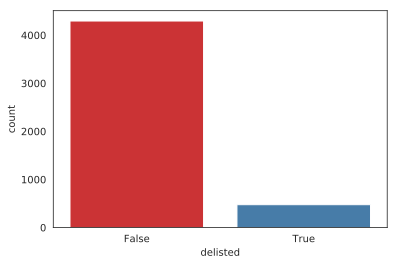

In [12]:
sns.countplot(x='delisted',palette="Set1", data=model_data);

In [13]:
count_no_delist = (model_data['delisted'] == 0).sum()
count_yes_delist = (model_data['delisted']==1).sum()

print("no_of_not_delisted_companies",count_no_delist)
print("no_of_delisted_companies",count_yes_delist)

percent_of_no_delist = count_no_delist/(count_no_delist+count_yes_delist)
print("percentage of no delisting is", percent_of_no_delist*100)

percent_of_yes_delist = count_yes_delist/(count_no_delist+count_yes_delist)
print("percentage of delisting", percent_of_yes_delist*100)

no_of_not_delisted_companies 4295
no_of_delisted_companies 475
percentage of no delisting is 90.0419287212
percentage of delisting 9.95807127883


Note: There is significant data imbalance so we will have to do either oversampling or under sampling<br>
Oversampling of delisted companyies makes sense as the total data points are not that high

### 3. SETUP DATA BEFORE MODELLING

In [14]:
# make X and y from dataframe
X = model_data.loc[:, model_data.columns != 'delisted']
y = model_data['delisted']
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (4770, 92)
Shape of y: (4770,)


#### A. TRAIN TEST SPLIT 

In [15]:
# Splitting the dataset in train and test
# Use stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED, stratify =y)

#### B. IMPUTE
##### Tweak2 - impute_type
Impute values. First fit and transform on X_train<br>
Use the same fit for the X_test and crystal_ball. <br>
Only transform these so that the same imputation that happened on X_train is replicated 

In [16]:
# Impute values for X_train
impute_type ='mean'
imp = Imputer(missing_values=np.nan, strategy=impute_type)
X_train = imp.fit_transform(X_train)

# only transform X_test

X_test = imp.transform(X_test)

# only transform the crystal_ball
crystal_ball.loc[:,'sa_total_income':'traded_qty']=imp.transform(crystal_ball.loc[:,'sa_total_income':'traded_qty'])

#write to crystal_ball_web_ready.csv ... this will be used by the api
crystal_ball.to_csv('../data/crystal_ball_web_ready.csv')

#### C. OVERSAMPLING

Carry out balancing the target variable with SMOTE (Synthetic Minority Oversampling Technique).
1. Works by creating synthetic samples from the minor class instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [17]:
print("BEFORE \n------------")
print("Number of Companies X_train dataset: ", X_train.shape)
print("Number of delisted Companies: {}".format(sum(y_train==1)))
print("Number of NOT delisted Companies: {}".format(sum(y_train==0)))

BEFORE 
------------
Number of Companies X_train dataset:  (3339, 92)
Number of delisted Companies: 333
Number of NOT delisted Companies: 3006


##### Tweak3 - SMOTE

In [18]:
smote = True
if ( smote == True):
    sm = SMOTE(random_state=0)
    X_train, y_train = sm.fit_sample(X_train, y_train)

    
print("AFTER \n------------")
print("Number of Companies X_train dataset: ", X_train.shape)
print("Number of delisted Companies: {}".format(sum(y_train==1)))
print("Number of NOT delisted Companies: {}".format(sum(y_train==0)))

AFTER 
------------
Number of Companies X_train dataset:  (6012, 92)
Number of delisted Companies: 3006
Number of NOT delisted Companies: 3006


#### D. SCALER

##### tweak4 - use standardscaler() 
NOT USING IN FINAL MODEL

In [19]:
scale_it = False
if(scale_it == True):
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

### E. PRINCIPLE COMPONENT ANALYSIS
NOT USING IN FINAL MODEL

In [20]:
# pca = PCA()
# pca.fit(X_train)
# plt.plot(pca.explained_variance_ratio_.cumsum().reshape(92,1), '--o')

In [21]:
# cumulative_varience_explained = pca.explained_variance_ratio_.cumsum().reshape(92,1)
# cumulative_varience_explained = pd.DataFrame(cumulative_varience_explained)
# cumulative_varience_explained.head(100)

##### tweak4 - use pca and set n_components 

In [22]:
# pca = False
# if(pca == True):
#     pca_opt = PCA(n_components=40)
#     pca_opt.fit(X_train)
#     X_train = pca_opt.transform(X_train)
#     X_test = pca_opt.transform(X_test)

### 4. FUNCTIONS FOR ROC CURVE AND REPORTING

In [23]:
def make_roc(model):    
    plt.rcParams['font.size'] = 14
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr,tpr)
    plt.figure(figsize=(4,4))
    # Plotting our Baseline..
    plt.plot([0,1],[0,1],'C1--', linewidth=2.0)
    plt.plot(fpr, tpr, 'C9',label='AUC = %0.3f'% roc_auc,linewidth=2.0)
    plt.legend(loc='lower right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate');

In [24]:
def make_report(model):
    from sklearn.metrics import confusion_matrix
    y_pred_rep = model.predict(X_test)
    accuracy_best =model.score(X_test, y_test)
    print("\nAccuracy of the best model is :",accuracy_best)
    confusion_matrix = confusion_matrix(y_test, y_pred_rep)
    print("\nConfusion Matrix \n-------------------\n",confusion_matrix)
    print("\nClassification Report \n---------------------")
    print(classification_report(y_test, y_pred_rep))
    

### 5. QUICK CLASSIFIER 

In [25]:
models = [('knn', KNN), 
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier)
         ]

param_choices = [
    {
        'n_neighbors': range(1, 12)
    },
    {
        'C': np.logspace(-3,6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    },
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [3,6,10]
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params,n_jobs=-1)
    grid.fit(X_train, y_train)
    s = f"{name}: best score: {grid.best_score_}"
    print(s)
    grids[name] = grid

knn: best score: 0.8943779108449768
logistic: best score: 0.7975715236194278
tree: best score: 0.8599467731204258
forest: best score: 0.8654357950765137


In [26]:
# Let's get the testing score
print(grids['knn'].best_estimator_.score(X_test, y_test))
print(grids['logistic'].best_estimator_.score(X_test, y_test))
print(grids['tree'].best_estimator_.score(X_test, y_test))
print(grids['forest'].best_estimator_.score(X_test, y_test))

0.818308874913
0.781271837876
0.830887491265
0.840670859539


In [27]:
reg_type = 'tree'

In [28]:
make_report(grids['forest'].best_estimator_)


Accuracy of the best model is : 0.840670859539

Confusion Matrix 
-------------------
 [[1107  182]
 [  46   96]]

Classification Report 
---------------------
             precision    recall  f1-score   support

      False       0.96      0.86      0.91      1289
       True       0.35      0.68      0.46       142

avg / total       0.90      0.84      0.86      1431



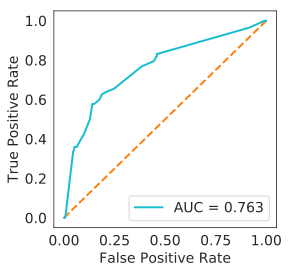

In [29]:
make_roc(grids['tree'].best_estimator_)

### 5. LOGISTIC REGRESSION 

In [30]:
#Setup the hyperparameter grid
c_space = np.logspace(-5, 5, 10)
param_grid = {'C': c_space}

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, n_jobs = -1)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

#examine the best model
print(logreg_cv.best_score_)
print(logreg_cv.best_params_)
print(logreg_cv.best_estimator_)
c_best = logreg_cv.best_params_

0.77877578177
{'C': 0.27825594022071259}
LogisticRegression(C=0.27825594022071259, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [34]:
best_lr = LogisticRegression(C=c_best['C'])
best_lr.fit(X_train, y_train)
pickle.dump(best_lr, open('./model_pickles/best_lr.pkl','wb'))
print("The score for training is ", best_lr.score(X_train, y_train))

The score for training is  0.777944111776


In [35]:
make_report(best_lr)


Accuracy of the best model is : 0.730258560447

Confusion Matrix 
-------------------
 [[946 343]
 [ 43  99]]

Classification Report 
---------------------
             precision    recall  f1-score   support

      False       0.96      0.73      0.83      1289
       True       0.22      0.70      0.34       142

avg / total       0.88      0.73      0.78      1431



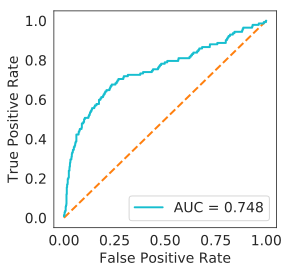

In [36]:
make_roc(best_lr)

### 6. RANDOM FOREST

In [25]:
# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
randomforest = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, scoring = 'roc_auc', cv = 5, n_iter = 10, verbose = 0, random_state=RSEED)


# Fit 
randomforest.fit(X_train, y_train)


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': array([ 10,  13,  17,  21,  25,  29,  33,  37,  41,  44,  48,  52,  56,
        60,  64,  68,  72,  75,  79,  83,  87,  91,  95,  99, 103, 106,
       110, 114, 118, 122, 126, 130, 134, 137, 141, 145, 149, 153, 157,
       161, 165, 168, 172, 176, 180, 184, 188, ...9, 49, 49, 49, 49, 49, 49, 49, 49, 50], 'min_samples_split': [2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=0, re

In [26]:
params = randomforest.best_params_
params

{'n_estimators': 25,
 'min_samples_split': 5,
 'max_leaf_nodes': 41,
 'max_features': 0.79999999999999993,
 'max_depth': 7,
 'bootstrap': True}

In [27]:
best_rf = RandomForestClassifier(n_estimators = params['n_estimators'],\
                                min_samples_split = params['min_samples_split'],
                                max_leaf_nodes=params['max_leaf_nodes'],\
                                max_features=params['max_features'],\
                                max_depth=params['max_depth'],\
                                bootstrap=params['bootstrap'])
                                                             
best_rf.fit(X_train,y_train)
pickle.dump(best_rf, open('./model_pickles/best_rf.pkl','wb'))
print(best_rf.score(X_train,y_train))

0.920825016633


In [28]:
features = best_rf.feature_importances_
#features.sort()
features

array([  1.02763209e-03,   1.60214075e-03,   7.89238251e-03,
         5.54487606e-04,   1.45773099e-02,   1.16619302e-03,
         1.75972294e-02,   3.65322427e-03,   8.68864841e-03,
         1.22456580e-02,   4.32539777e-04,   3.36934384e-03,
         3.07954415e-04,   4.79452728e-03,   3.07014200e-03,
         2.39895441e-03,   4.18386527e-03,   2.36710758e-02,
         1.21306576e-03,   3.03279907e-03,   7.58812521e-04,
         1.99155252e-04,   2.73150623e-04,   1.59201222e-03,
         1.76256999e-03,   7.30254367e-03,   1.28107222e-03,
         5.40669100e-03,   1.22660442e-02,   0.00000000e+00,
         4.69247462e-03,   4.35340871e-03,   1.04229621e-03,
         1.14846421e-03,   6.75851464e-04,   3.96048978e-03,
         0.00000000e+00,   9.77637033e-03,   3.10567283e-03,
         2.41659879e-03,   1.55201128e-03,   2.82242206e-03,
         2.03056616e-03,   3.27714070e-03,   1.46548569e-03,
         2.07192947e-03,   1.69112054e-03,   3.56452960e-03,
         5.34476927e-04,

In [29]:
make_report(best_rf)


Accuracy of the best model is : 0.863032844165

Confusion Matrix 
-------------------
 [[1161  128]
 [  68   74]]

Classification Report 
---------------------
             precision    recall  f1-score   support

      False       0.94      0.90      0.92      1289
       True       0.37      0.52      0.43       142

avg / total       0.89      0.86      0.87      1431



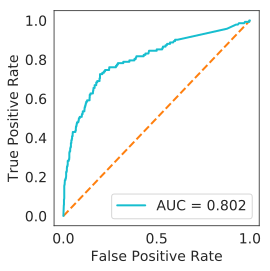

In [30]:
make_roc(best_rf)
plt.tight_layout()
plt.savefig('ROC.png',format='png',transparent=True)

### 7. Gradient Boosting

In [34]:
#from skopt import BayesSearchCV
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')
    
param_grid = {
    'max_leaf_nodes': (3,7),
    'loss': ('deviance','exponential'),
    'learning_rate': (1e-5, 1, 'log-uniform'),
    'n_estimators': (50,500)}


grad_boost = GradientBoostingClassifier()
grad_model = BayesSearchCV(grad_boost, param_grid , n_iter =  20, scoring = 'roc_auc',n_jobs = -1)
grad_model.fit(X_train, y_train)

BayesSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_iter=20, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='roc_auc',
       search_spaces={'max_leaf_nodes': (3, 7), 'loss': ('deviance', 'exponential'), 'learning_rate': (1e-05, 1, 'log-uniform'), 'n_estimators': (50, 500)},
       verbose=0)

In [35]:
params = grad_model.best_params_
params

{'learning_rate': 0.29826266814697933,
 'loss': 'exponential',
 'max_leaf_nodes': 7,
 'n_estimators': 500}

In [36]:
best_gb = GradientBoostingClassifier()
                                                             
best_gb.fit(X_train,y_train)
pickle.dump(best_gb, open('./model_pickles/best_gb.pkl','wb'))
print(best_gb.score(X_train,y_train))

0.947604790419


In [37]:
make_report(grad_model)


Accuracy of the best model is : 0.810121395557

Confusion Matrix 
-------------------
 [[1235   54]
 [  85   57]]

Classification Report 
---------------------
             precision    recall  f1-score   support

      False       0.94      0.96      0.95      1289
       True       0.51      0.40      0.45       142

avg / total       0.89      0.90      0.90      1431



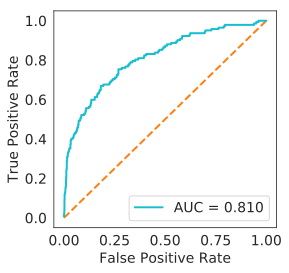

In [38]:
make_roc(grad_model)

In [39]:
#best_gb.feature_importances_

array([  2.08141136e-03,   0.00000000e+00,   1.32280451e-02,
         0.00000000e+00,   1.74157155e-03,   0.00000000e+00,
         5.91298475e-03,   8.20201983e-03,   7.86008408e-03,
         7.76680508e-03,   3.67538545e-03,   6.04333757e-03,
         5.96800543e-03,   8.02330587e-03,   3.21316424e-03,
         1.64013189e-02,   1.38921802e-03,   3.16076137e-02,
         6.15706290e-03,   5.37529150e-03,   1.28385626e-02,
         0.00000000e+00,   4.89092441e-03,   8.62397859e-03,
         1.36769106e-02,   1.21468350e-02,   0.00000000e+00,
         5.43415446e-03,   4.51635552e-02,   1.91025776e-03,
         1.14228720e-02,   5.50760245e-03,   7.15184257e-03,
         6.28065142e-03,   1.30061610e-03,   4.26333295e-03,
         0.00000000e+00,   2.74867735e-02,   0.00000000e+00,
         0.00000000e+00,   2.78572412e-03,   2.75228436e-05,
         7.88534576e-04,   1.90261700e-03,   9.75494474e-03,
         7.06972071e-03,   7.54839835e-03,   1.14775354e-03,
         1.08383426e-02,

### 8. SVM

In [40]:
# Finding best parameters for linear kernel.
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_estimator_



In [ ]:
make_roc(svc_param_selection(X_train,y_train,5))

In [ ]:
params = svc_param_selection(X_train,y_train,5)
params

### 9. THRESHOLD SETTING
My Best Model is the Random Forest Model which has been picked as best_rf.pkl
I picked the random forest over gradient boosting as the recall was much better and False Negatives were lower

In [37]:
import pickle
pipeline = pickle.load(open('./model_pickles/best_rf.pkl', 'rb'))
#pipeline = pickle.load(open('./model_pickles/best_gb.pkl', 'rb'))


Confusion Matrix 
-------------------
 [[757 532]
 [ 26 116]]

Classification Report 
---------------------
             precision    recall  f1-score   support

      False       0.97      0.59      0.73      1289
       True       0.18      0.82      0.29       142

avg / total       0.89      0.61      0.69      1431



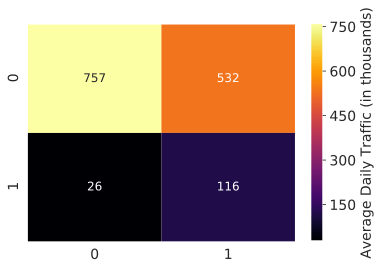

In [38]:
def threshold_maker(threshold):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    y_pred_proba = pipeline.predict_proba(X_test)[:,1]  
    y_pred_rep = np.where(y_pred_proba>threshold,1,0)
    confusion_matrix = confusion_matrix(y_test, y_pred_rep)   
    print("\nConfusion Matrix \n-------------------\n",confusion_matrix)
    print("\nClassification Report \n---------------------")
    #d = classification_report(y_test, y_pred_rep).split()
    #print(d)
    sns.heatmap(
    confusion_matrix,
    fmt=".0f",
    cmap='inferno',
    annot=True,
    annot_kws={"size": 12},
    cbar_kws={'label': "Average Daily Traffic (in thousands)"},   
    )
    print(classification_report(y_test, y_pred_rep))
    #return d

threshold_maker(0.1)    
    